Se importan las librerias necesarias.

In [1]:
from scipy.integrate import odeint
from scipy.signal import resample

In [2]:
from numpy import array, linspace, matrix, interp, sort
from numpy.random import normal
from numpy.linalg import pinv, eig

In [3]:
from control import tf, forced_response

In [4]:
from matplotlib.pyplot import figure, style
from matplotlib import rc
style.use("ggplot")
rc('font',**{'family':'serif','serif':['Palatino'], 'size':14.0})
rc('text', usetex=True)
%matplotlib inline

Se definen funciones a simular y auxiliares.

In [17]:
def escalon(x, t, mag):
    '''
    Esta función toma un vector con el estado del sistema, el tiempo de simulación
    y la magnitud del escalon a simular, y da como resultado el valor de la función
    escalón en el tiempo requerido.
    '''
    if t <= 0:
        y = 0
    else:
        y = mag
    return y

def senoidal(x, t, mag, frec):
    '''
    Esta función toma un vector con el estado del sistema, el tiempo de simulación,
    la magnitud y frecuencia de una función senoidal, y da como resultado el valor de
    esta en el tiempo requerido.
    '''
    from numpy import sin
    if t <=  0:
        y = 0
    else:
        y = mag*sin(frec*t)
    return y

def motor_cd(x, t, entrada):
    '''
    Esta función toma un vector con el estado del sistema, el tiempo de simulación, 
    y nombre de función de entrada, y da como resultado la derivada del sistema,
    calculada a partir de la dinámica simplificada de un motor de corriente directa y de
    la señal de entrada del motor.
    '''
    y, ẏ, ÿ = x
    
    Kb, Ka, K = (6/(120/60)), 10, ((0.936*9.81/100)/(0.42))
    L, R = 0.0316, 12.8
    J, B = 2*0.00000002945, 0.00000098734
    u = entrada(x, t)
    us.append([t,u])
    yppp = (1/(L*J))*(K*Ka*u - (L*B + R*J)*ÿ - (R*B + Kb*K)*ẏ)
    return ẏ, ÿ, yppp

def control_pd(x, t, referencia, kp = 1, kd = 0):
    '''
    Esta función toma un vector con el estado del sistema, el tiempo de simulación,
    nombre de función de entrada (referencia) y ganancias proporcionales y derivativas,
    y da como resultado la señal de control para un algoritmo PD, deacuerdo al estado
    del sistema y la referencia de entrada.
    '''
    y, ẏ, ÿ = x
    yd = referencia(x, t)
    refs.append([t, yd])
    e = yd - y
    es.append([t, e])
    ė = 0 - ẏ
    salida = kp*e + kd*ė
    return salida

def filtro_primer_orden(estado, t, entrada, a):
    '''
    Esta función se utiliza para filtrar una señal compleja, posiblemente no derivable,
    y obtener una señal mas amable con un servomecanismo fisico. Es un filtro de primer
    orden el cual toma como entrada el estado del sistema, el tiempo de simulación,
    el nombre de la señal de entrada y una ganancia a asociada al filtro, y da como 
    resultado la señal filtrada en el tiempo dado.
    '''
    y = estado
    u = entrada(estado, t)
    salida = a*u - a*y
    return salida

def ruido(t0, tf, h):
    '''
    Esta función toma los valores para el tiempo inicial, tiempo final y periodo de
    integración h, y da como resultado una señal, empezando y finalizando en los
    tiempos dados, y con una distancia temporal de acuerdo al tiempo de integración,
    de manera aleatoria, de acuerdo a una distribución normal, la cual ha sido
    tratada para que sea adecuada para la identificación de parametros de un
    servomecanismo.
    '''
    from numpy.random import normal
    from numpy import linspace
    from scipy.signal import resample
    
    t = h*10
    n = int(1/t)
    ruido = normal(0, 0.1, n)
    ts = linspace(t0, tf, n)

    ruido, ts = resample(ruido, n*10+1, ts)
    
    return ts, ruido

def alimentador(x, t, ts, xs):
    '''
    Esta función toma un vector con el estado del sistema, el tiempo de simulación,
    y un par de arreglos con un conjunto de datos, y da como resultado el valor de
    la señal descrita en el segundo arreglo, en el tiempo dado por el tiempo de simulación.
    Este valor se calcula por medio de una interpolación.
    '''
    from numpy import interp
    salida = interp(t, ts, xs)
    return salida

Se genera una señal de ruido blanco para la identificación de parametros.

In [18]:
ts, ss = ruido(0, 10, 0.001)
x0 = [0, 0]
s1 = lambda x, t: alimentador(x, t, ts, ss)
datos = odeint(filtro_primer_orden, x0, ts, args=(s1, 20))
s2, _ = zip(*datos)

Se simula motor simplificado con la señal de ruido blanco como entrada y un control PD en lazo cerrado para estabilizar el sistema.

In [19]:
x0 = [0, 0, 0]
en1 = lambda x, t: alimentador(x, t, ts, s2)
u1 = lambda x, t: control_pd(x, t, en1, 50, 10)
us = []
es = []
refs = []
datos = odeint(motor_cd, x0, ts, args=(u1,), mxstep=500000, rtol=1e-03, atol=1e-03)
y, yp, ypp = zip(*datos)

Los arreglos guardados ($u$, $e$ y $ref$) se acomodan de acuerdo al tiempo en que se simularon.

In [20]:
us.sort()
es.sort()
refs.sort()

Se interpola una señal de cada unos de estos arreglos, de acuerdo a los tiempos de simulación.

In [21]:
tus, uus = zip(*us)
señ_control = interp(ts, tus, uus)

tes, ees = zip(*es)
errores = interp(ts, tes, ees)

trefs,rrefs = zip(*refs)
referencia = interp(ts, trefs, rrefs)

Se grafican las señales de referencia y posición, velocidad, control y error.

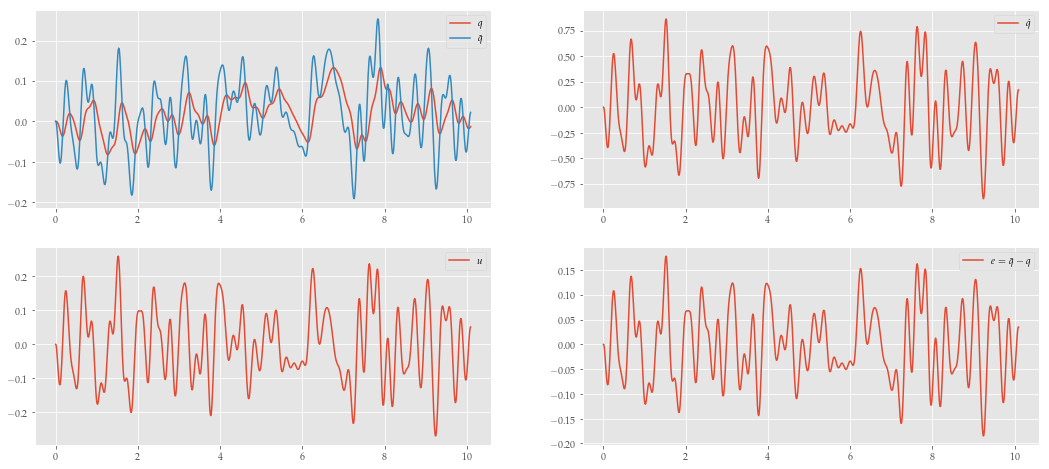

In [22]:
fig = figure(figsize=(18,8))
[ax1, ax2], [ax3, ax4] = fig.subplots(2,2)
p1, = ax1.plot(ts, y)
pr, = ax1.plot(ts, referencia)
p2, = ax2.plot(ts, yp)
p3, = ax3.plot(ts, señ_control)
p4, = ax4.plot(ts, errores)
ax1.legend([p1, pr], [r"$q$", r"$\tilde{q}$"])
ax2.legend([p2], [r"$\dot{q}$"])
ax3.legend([p3], [r"$u$"])
ax4.legend([p4], [r"$e = \tilde{q} - q$"]);

Se definen las funciones de transferencia de filtros de orden 2, 1, y 0.

In [23]:
fso2 = tf([400, 0, 0], [1, 40, 400])
fso1 = tf([-400, 0], [1, 40, 400])
fso0 = tf([400], [1, 40, 400])

Se alimentan las señales de posición y control a estos filtros para obtener una estimación de la aceleración, velocidad y la señal de control filtrada.

In [24]:
ts,  B, xs = forced_response(fso2, ts, y)
ts, A1, xs = forced_response(fso1, ts, y)
ts, A2, xs = forced_response(fso0, ts, señ_control)

Se define una matriz con los datos de la simulación para estimar los parametros de la planta.

In [25]:
A = matrix([A1, A2]).T

In [26]:
B = matrix(B).T

Se obtiene la solución del sistema utilizando la seudoinversa de la matriz $A$.

In [27]:
θ = pinv(A)*B
θ

matrix([[ -3435.26478139],
        [-11436.77596959]])

In [28]:
λs, E = eig(A.T*A)
λmax, λmin = max(λs), min(λs)
κ = λmax/λmin
κ

5028745.3585022865